In [89]:
import os
import numpy as np
import pandas as pd
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

In [90]:
TRAIN_DIR = 'images/train'
TEST_DIR = 'images/test'
IMAGE_SIZE = 96
BATCH_SIZE = 64
NUM_EPOCHS = 30
LEARNING_RATE = 0.0016
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(DEVICE)

EMOTIONS = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

cuda


In [91]:
class EmotionDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('L')

        if self.transform:
            image = self.transform(image)

        label = self.labels[idx]
        return image, label

In [92]:
def create_dataframe(dir):
    image_paths = []
    labels = []
    for label in os.listdir(dir):
        label_dir = os.path.join(dir, label)
        if os.path.isdir(label_dir):  # Ensure it's a directory
            for image_name in os.listdir(label_dir):
                image_paths.append(os.path.join(dir, label, image_name))
                labels.append(label)
            print(f"{label} completed")
    return image_paths, labels

In [93]:
def get_label_idx(label_name):
    return EMOTIONS.index(label_name)

In [94]:
transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

In [95]:
# Create datasets and loaders
def create_datasets():
    # Get train data
    train_image_paths, train_label_names = create_dataframe(TRAIN_DIR)
    train_labels = [get_label_idx(label) for label in train_label_names]

    # Get test data
    test_image_paths, test_label_names = create_dataframe(TEST_DIR)
    test_labels = [get_label_idx(label) for label in test_label_names]

    # Create datasets
    train_dataset = EmotionDataset(train_image_paths, train_labels, transform)
    test_dataset = EmotionDataset(test_image_paths, test_labels, transform)

    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

    return train_loader, test_loader

In [96]:
class EmotionCNN(nn.Module):
    def __init__(self, num_classes=7):
        super(EmotionCNN, self).__init__()

        # Convolutional layers
        self.conv1 = nn.Conv2d(1, 128, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout1 = nn.Dropout(0.2)

        self.conv2 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout2 = nn.Dropout(0.2)

        self.conv3 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout3 = nn.Dropout(0.2)

        # Calculate the size after convolutions
        # After 3 pooling layers of stride 2, the 48x48 image becomes 6x6
        self.flat_features = 512 * 12 * 12

        # Fully connected layers
        self.fc1 = nn.Linear(self.flat_features, 512)
        self.dropout4 = nn.Dropout(0.2)
        self.fc2 = nn.Linear(512, 256)
        self.dropout5 = nn.Dropout(0.2)
        self.fc3 = nn.Linear(256, num_classes)

    def forward(self, x):
        # Convolutional layers
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = self.dropout1(x)

        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        x = self.dropout2(x)

        x = F.relu(self.conv3(x))
        x = self.pool3(x)
        x = self.dropout3(x)

        # Flatten
        x = x.view(-1, self.flat_features)

        # Fully connected layers
        x = F.relu(self.fc1(x))
        x = self.dropout4(x)
        x = F.relu(self.fc2(x))
        x = self.dropout5(x)
        x = self.fc3(x)

        return x

In [97]:
def train_model(model, train_loader, test_loader, criterion, optimizer, num_epochs):
    best_accuracy = 0.0

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for inputs, labels in tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}'):
            inputs = inputs.to(DEVICE)
            labels = labels.to(DEVICE)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Backward pass and optimize
            loss.backward()
            optimizer.step()

            # Statistics
            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = correct / total

        # Validation phase
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for inputs, labels in tqdm(test_loader, desc='Validation'):
                inputs = inputs.to(DEVICE)
                labels = labels.to(DEVICE)

                outputs = model(inputs)
                loss = criterion(outputs, labels)

                val_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        val_loss = val_loss / len(test_loader.dataset)
        val_acc = val_correct / val_total

        print(f'Epoch {epoch+1}/{num_epochs}:')
        print(f'Train Loss: {epoch_loss:.4f} | Train Acc: {epoch_acc:.4f}')
        print(f'Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}')

        # Save best model
        if val_acc > best_accuracy:
            best_accuracy = val_acc
            torch.save(model.state_dict(), 'emotion_model.pth')
            print(f'Model saved with accuracy: {best_accuracy:.4f}')

    print(f'Best validation accuracy: {best_accuracy:.4f}')

In [98]:
def predict_emotion(model, image_path):
    model.eval()

    # Open and preprocess the image
    image = Image.open(image_path).convert('L')  # Convert to grayscale
    image = transform(image).unsqueeze(0).to(DEVICE)  # Add batch dimension

    # Make prediction
    with torch.no_grad():
        outputs = model(image)
        _, predicted = torch.max(outputs, 1)

    return EMOTIONS[predicted.item()]

Using device: cuda
angry completed
disgust completed
fear completed
happy completed
neutral completed
sad completed
surprise completed
angry completed
disgust completed
fear completed
happy completed
neutral completed
sad completed
surprise completed


Validation: 100%|██████████| 111/111 [00:07<00:00, 14.12it/s]


Epoch 1/30:
Train Loss: 1.6970 | Train Acc: 0.3187
Val Loss: 1.5411 | Val Acc: 0.4106
Model saved with accuracy: 0.4106


Validation: 100%|██████████| 111/111 [00:07<00:00, 14.97it/s]


Epoch 2/30:
Train Loss: 1.4527 | Train Acc: 0.4400
Val Loss: 1.3495 | Val Acc: 0.4765
Model saved with accuracy: 0.4765


Validation: 100%|██████████| 111/111 [00:07<00:00, 14.95it/s]


Epoch 3/30:
Train Loss: 1.3177 | Train Acc: 0.4901
Val Loss: 1.2989 | Val Acc: 0.4953
Model saved with accuracy: 0.4953


Validation: 100%|██████████| 111/111 [00:07<00:00, 14.77it/s]


Epoch 4/30:
Train Loss: 1.2098 | Train Acc: 0.5410
Val Loss: 1.2482 | Val Acc: 0.5248
Model saved with accuracy: 0.5248


Validation: 100%|██████████| 111/111 [00:07<00:00, 14.15it/s]


Epoch 5/30:
Train Loss: 1.1098 | Train Acc: 0.5804
Val Loss: 1.2203 | Val Acc: 0.5416
Model saved with accuracy: 0.5416


Validation: 100%|██████████| 111/111 [00:07<00:00, 14.33it/s]


Epoch 6/30:
Train Loss: 1.0079 | Train Acc: 0.6169
Val Loss: 1.2244 | Val Acc: 0.5385


Validation: 100%|██████████| 111/111 [00:07<00:00, 14.85it/s]


Epoch 7/30:
Train Loss: 0.9097 | Train Acc: 0.6552
Val Loss: 1.2455 | Val Acc: 0.5447
Model saved with accuracy: 0.5447


Validation: 100%|██████████| 111/111 [00:07<00:00, 14.72it/s]


Epoch 8/30:
Train Loss: 0.8115 | Train Acc: 0.6973
Val Loss: 1.2568 | Val Acc: 0.5531
Model saved with accuracy: 0.5531


Validation: 100%|██████████| 111/111 [00:09<00:00, 11.53it/s]


Epoch 9/30:
Train Loss: 0.7374 | Train Acc: 0.7253
Val Loss: 1.2885 | Val Acc: 0.5514


Validation: 100%|██████████| 111/111 [00:13<00:00,  8.34it/s]


Epoch 10/30:
Train Loss: 0.6630 | Train Acc: 0.7585
Val Loss: 1.3086 | Val Acc: 0.5548
Model saved with accuracy: 0.5548


Validation: 100%|██████████| 111/111 [00:13<00:00,  8.46it/s]


Epoch 11/30:
Train Loss: 0.6069 | Train Acc: 0.7786
Val Loss: 1.3199 | Val Acc: 0.5508


Validation: 100%|██████████| 111/111 [00:13<00:00,  8.04it/s]


Epoch 12/30:
Train Loss: 0.5512 | Train Acc: 0.7994
Val Loss: 1.3876 | Val Acc: 0.5495


Validation: 100%|██████████| 111/111 [00:13<00:00,  7.95it/s]


Epoch 13/30:
Train Loss: 0.5079 | Train Acc: 0.8181
Val Loss: 1.4508 | Val Acc: 0.5538


Validation: 100%|██████████| 111/111 [00:13<00:00,  8.04it/s]


Epoch 14/30:
Train Loss: 0.4618 | Train Acc: 0.8340
Val Loss: 1.4231 | Val Acc: 0.5563
Model saved with accuracy: 0.5563


Validation: 100%|██████████| 111/111 [00:13<00:00,  8.22it/s]


Epoch 15/30:
Train Loss: 0.4439 | Train Acc: 0.8413
Val Loss: 1.4387 | Val Acc: 0.5573
Model saved with accuracy: 0.5573


Validation: 100%|██████████| 111/111 [00:14<00:00,  7.88it/s]


Epoch 16/30:
Train Loss: 0.4089 | Train Acc: 0.8578
Val Loss: 1.4976 | Val Acc: 0.5511


Validation: 100%|██████████| 111/111 [00:13<00:00,  8.27it/s]


Epoch 17/30:
Train Loss: 0.3817 | Train Acc: 0.8682
Val Loss: 1.5395 | Val Acc: 0.5563


Validation: 100%|██████████| 111/111 [00:13<00:00,  8.17it/s]


Epoch 18/30:
Train Loss: 0.3672 | Train Acc: 0.8731
Val Loss: 1.5251 | Val Acc: 0.5536


Validation: 100%|██████████| 111/111 [00:27<00:00,  4.08it/s]


Epoch 19/30:
Train Loss: 0.3511 | Train Acc: 0.8794
Val Loss: 1.4799 | Val Acc: 0.5604
Model saved with accuracy: 0.5604


Validation: 100%|██████████| 111/111 [00:08<00:00, 13.23it/s]


Epoch 20/30:
Train Loss: 0.3298 | Train Acc: 0.8871
Val Loss: 1.5002 | Val Acc: 0.5539


Validation: 100%|██████████| 111/111 [00:08<00:00, 13.52it/s]


Epoch 21/30:
Train Loss: 0.3105 | Train Acc: 0.8936
Val Loss: 1.5269 | Val Acc: 0.5491


Validation: 100%|██████████| 111/111 [00:11<00:00,  9.71it/s]


Epoch 22/30:
Train Loss: 0.3081 | Train Acc: 0.8946
Val Loss: 1.5279 | Val Acc: 0.5579


Validation: 100%|██████████| 111/111 [00:13<00:00,  8.48it/s]


Epoch 23/30:
Train Loss: 0.2924 | Train Acc: 0.8997
Val Loss: 1.6030 | Val Acc: 0.5548


Validation: 100%|██████████| 111/111 [00:09<00:00, 11.14it/s]


Epoch 24/30:
Train Loss: 0.2798 | Train Acc: 0.9046
Val Loss: 1.5673 | Val Acc: 0.5566


Validation: 100%|██████████| 111/111 [00:13<00:00,  8.32it/s]


Epoch 25/30:
Train Loss: 0.2766 | Train Acc: 0.9048
Val Loss: 1.6125 | Val Acc: 0.5543


Validation: 100%|██████████| 111/111 [00:13<00:00,  8.29it/s]


Epoch 26/30:
Train Loss: 0.2676 | Train Acc: 0.9109
Val Loss: 1.6046 | Val Acc: 0.5575


Validation: 100%|██████████| 111/111 [00:12<00:00,  9.25it/s]


Epoch 27/30:
Train Loss: 0.2590 | Train Acc: 0.9129
Val Loss: 1.6163 | Val Acc: 0.5592


Validation: 100%|██████████| 111/111 [00:13<00:00,  8.45it/s]


Epoch 28/30:
Train Loss: 0.2503 | Train Acc: 0.9153
Val Loss: 1.6383 | Val Acc: 0.5590


Validation: 100%|██████████| 111/111 [00:13<00:00,  8.28it/s]


Epoch 29/30:
Train Loss: 0.2395 | Train Acc: 0.9195
Val Loss: 1.6401 | Val Acc: 0.5517


Validation: 100%|██████████| 111/111 [00:13<00:00,  8.52it/s]


Epoch 30/30:
Train Loss: 0.2417 | Train Acc: 0.9195
Val Loss: 1.6116 | Val Acc: 0.5553
Best validation accuracy: 0.5604


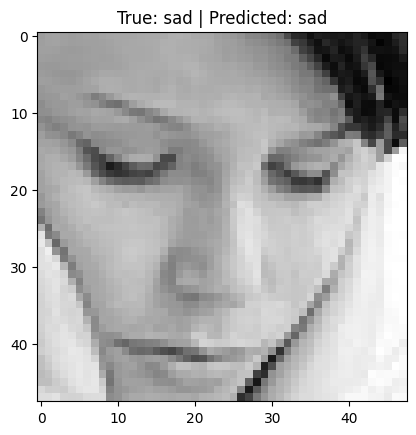

Original image is of sad
Model prediction is sad


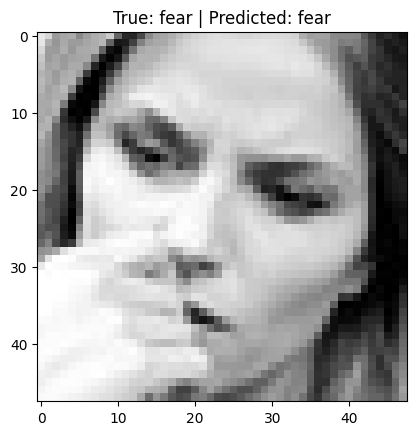

Original image is of fear
Model prediction is fear


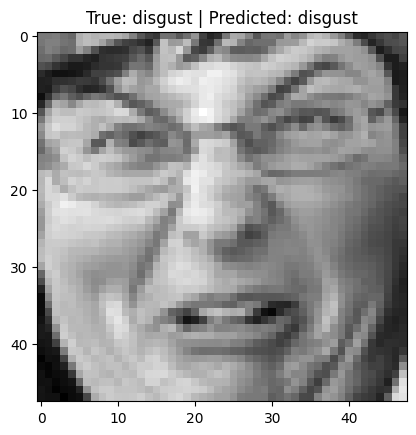

Original image is of disgust
Model prediction is disgust


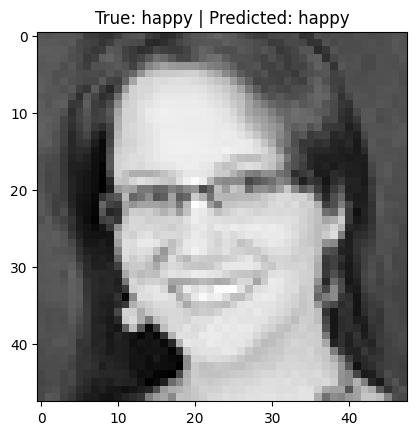

Original image is of happy
Model prediction is happy


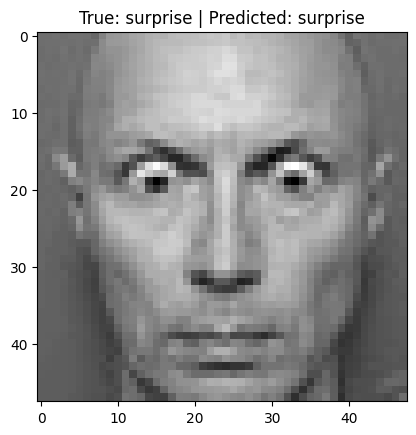

Original image is of surprise
Model prediction is surprise


In [99]:
def main():
    print(f"Using device: {DEVICE}")

    # Create data loaders
    train_loader, test_loader = create_datasets()

    # Initialize model
    model = EmotionCNN().to(DEVICE)

    # Loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

    # Train model
    train_model(model, train_loader, test_loader, criterion, optimizer, NUM_EPOCHS)

    # Load best model
    model.load_state_dict(torch.load('emotion_model.pth'))

    # Test some example images
    test_images = [
        'images/train/sad/42.jpg',
        'images/train/fear/2.jpg',
        'images/train/disgust/299.jpg',
        'images/train/happy/7.jpg',
        'images/train/surprise/15.jpg'
    ]

    for image_path in test_images:
        true_label = image_path.split('/')[-2]
        predicted_label = predict_emotion(model, image_path)

        # Display image with prediction
        img = Image.open(image_path).convert('L')
        plt.imshow(img, cmap='gray')
        plt.title(f'True: {true_label} | Predicted: {predicted_label}')
        plt.show()
        print(f"Original image is of {true_label}")
        print(f"Model prediction is {predicted_label}")

if __name__ == "__main__":
    main()